# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [1]:
from utils.dataloaders import get_mnist_dataloaders, get_celeba_dataloader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from disentanglement_lib.data.ground_truth import dsprites
import os
import torch
from tensorflow import gfile
import numpy as np


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

dsprites.DSprites
IMAGE_PATH = 'img_align_celeba/'
image_size = 64
# SAMPLE_PATH = '../'
DSPRITES_PATH = "/home/ISO/Pruned_VAE/data/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
with gfile.Open(DSPRITES_PATH, "rb") as data_file:
    # Data was saved originally using python2, so we need to set the encoding.
    data = np.load(data_file, encoding="latin1", allow_pickle=True)
# if not os.path.exists(SAMPLE_PATH):
#     os.makedirs(SAMPLE_PATH)
    
    
transform = transforms.Compose([
    #transforms.Scale(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_loader = ImageFolder(IMAGE_PATH, transform)


#data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
valid_loader, train_loader, test_loader = get_celeba_dataloader(data_loader, 
                                                                batch_size=128)
test_batch = iter(test_loader)
test_batch = next(test_batch)
new_labels =torch.tensor(test_batch[1])
print(torch.tensor(test_batch[0]).shape)
#latent_dist = model.encode(torch.tensor(test_batch[0]).cuda())




162079 20259 20261
torch.Size([128, 3, 64, 64])


/data/anaconda/envs/mli/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/data/anaconda/envs/mli/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [2]:
print(data["imgs"].shape)

(737280, 64, 64)


In [17]:
import torch
import numpy as np
import torch.utils.data as utils
from PIL import Image
from torch.nn.functional import normalize
trans = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#print(np.mean(data["imgs"]),np.std(data["imgs"]))
#####train
print(normalize(torch.tensor(data["imgs"]).to(dtype=torch.float32)).min())
train_x = normalize(torch.tensor(data["imgs"][:649600,:,:]).to(dtype=torch.float32)) # a list of numpy arrays
train_y = torch.zeros((data["imgs"][:649600,:,:].shape[0],1)) # another list of numpy arrays (targets)
train_set = utils.TensorDataset(train_x,train_y) # create your datset
train_loader = utils.DataLoader(train_set, batch_size=64) # create your dataloader

#####test
test_x = normalize(torch.tensor(data["imgs"][649600:704000,:,:]).to(dtype=torch.float32)) # a list of numpy arrays
test_y = torch.zeros((data["imgs"][649600:704000,:,:].shape[0],1)) # another list of numpy arrays (targets)
test_set = utils.TensorDataset(test_x,test_y) # create your datset
test_loader = utils.DataLoader(test_set, batch_size=64) # create your dataloader

#####valid
valid_x = normalize( torch.tensor(data["imgs"][700000:,:,:]).to(dtype=torch.float32))# a list of numpy arrays
valid_y = torch.zeros((data["imgs"][700000:,:,:].shape[0],1)) # another list of numpy arrays (targets)
valid_set = utils.TensorDataset(valid_x,valid_y) # create your datset
valid_loader = utils.DataLoader(valid_set, batch_size=64) # create your dataloader


tensor(0.)


### Define latent distribution of the model

In [18]:
from utils.dataloaders import get_mnist_dataloaders, get_celeba_dataloader 
from torchvision import transforms 
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader 
import os 
import torch
from jointvae.models_f import VAE
from jointvae.training import Trainer
from torch import optim
from viz.visualize_c import Visualizer
import matplotlib.pyplot as plt
import numpy as np



#valid_loader, train_loader, test_loader = get_mnist_dataloaders(batch_size=64)

# Latent distribution will be joint distribution of 10 gaussian normal distributions  7-14
# and one 10 dimensional Gumbel Softmax distribution
n_cont = 10
disc = []
n_disc = len(disc)
latent_spec = {'cont': n_cont,
               'disc': disc}

device = torch.device('cuda')
model = VAE(latent_spec=latent_spec, img_size=(1, 64, 64)).cuda()
# model = VAE(latent_spec=latent_spec, img_size=(1, 32, 32)).cuda()
print(model)


lr=0.00005
# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Define the capacities
# Continuous channels
gamma=1.0
cont_capacity = [0.0, 0.0, 25000, gamma]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 0.0, 25000, gamma]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0


lambda_d = 2
lambda_od = 10*lambda_d
lambda_dis = 20*lambda_d 
path="./Evaluations/".format(n_cont,gamma,lambda_d)
# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,lambda_d = lambda_d,
                  lambda_od = lambda_od, lambda_dis = lambda_dis )
# Build a visualizer which will be passed to trainer to visualize progress during training
viz = Visualizer(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_latent): Sequential(
    (0): L0Pair(256 -> 2*10, droprate_init=0.2, lamba=0.1, temperature=0.05, weight_decay=0.001, local_rep=False)
  )
  (fc_alphas): ModuleList()
  (latent_to_features): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2

### Build a model

### Train the model

from jointvae.training import Trainer


trainer._train_epoch(train_loader,valid_loader)

In [ ]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo
###1e-5 6859 1e-4 6727 5e-4 6722 try tanh/L1 loss/beta--->DIP
import time

start = time.time()
trainer.train(train_loader,valid_loader, epochs=50, save_training_gif=('./training.gif', viz))
end = time.time()
print(end - start)
torch.save(trainer.best_model.state_dict(), 'model_params.pkl')
torch.save(trainer.best_model, './model')
##15.078 - 0.0147  17.209 - 0.0168 error tanh 
##LR 1e-3 0.019-0.023 worse should pick 5e-4
##PLOT THE CURVE!!!!!
###3360

0/649600	Loss: 1665.873	L0 Loss: 0.529
3200/649600	Loss: 1652.259	L0 Loss: 0.529
6400/649600	Loss: 1618.457	L0 Loss: 0.529
9600/649600	Loss: 1230.365	L0 Loss: 0.529
12800/649600	Loss: 1066.357	L0 Loss: 0.529
16000/649600	Loss: 1053.292	L0 Loss: 0.529
19200/649600	Loss: 1045.385	L0 Loss: 0.529
22400/649600	Loss: 1041.192	L0 Loss: 0.529
25600/649600	Loss: 1039.395	L0 Loss: 0.529
28800/649600	Loss: 1037.769	L0 Loss: 0.529
32000/649600	Loss: 1036.850	L0 Loss: 0.529
35200/649600	Loss: 1033.188	L0 Loss: 0.530
38400/649600	Loss: 1029.240	L0 Loss: 0.530
41600/649600	Loss: 1026.996	L0 Loss: 0.530
44800/649600	Loss: 1021.457	L0 Loss: 0.530
48000/649600	Loss: 1020.095	L0 Loss: 0.530
51200/649600	Loss: 1019.855	L0 Loss: 0.530
54400/649600	Loss: 1019.647	L0 Loss: 0.530
57600/649600	Loss: 1019.306	L0 Loss: 0.530
60800/649600	Loss: 1019.339	L0 Loss: 0.530
64000/649600	Loss: 1019.502	L0 Loss: 0.530
67200/649600	Loss: 1019.156	L0 Loss: 0.530
70400/649600	Loss: 1018.928	L0 Loss: 0.530
73600/649600	Loss:

604800/649600	Loss: 1016.387	L0 Loss: 0.533
608000/649600	Loss: 1016.106	L0 Loss: 0.533
611200/649600	Loss: 1015.924	L0 Loss: 0.533
614400/649600	Loss: 1014.967	L0 Loss: 0.534
617600/649600	Loss: 1009.091	L0 Loss: 0.534
620800/649600	Loss: 1009.316	L0 Loss: 0.534
624000/649600	Loss: 1009.662	L0 Loss: 0.534
627200/649600	Loss: 1009.787	L0 Loss: 0.534
630400/649600	Loss: 1008.886	L0 Loss: 0.534
633600/649600	Loss: 1008.369	L0 Loss: 0.534
636800/649600	Loss: 1007.961	L0 Loss: 0.534
640000/649600	Loss: 1008.568	L0 Loss: 0.534
643200/649600	Loss: 1008.538	L0 Loss: 0.534
646400/649600	Loss: 1009.294	L0 Loss: 0.534
Valid Loss: 1048.731, Recon Error: 0.239
1048.7308802923658
Epoch: 1 Average loss: 1017.67 Valid loss: 1048.7308802923658	Recon Error:0.239
0/649600	Loss: 1017.321	L0 Loss: 0.534
3200/649600	Loss: 1018.877	L0 Loss: 0.534
6400/649600	Loss: 1018.232	L0 Loss: 0.534
9600/649600	Loss: 1018.101	L0 Loss: 0.534
12800/649600	Loss: 1018.728	L0 Loss: 0.534
16000/649600	Loss: 1018.170	L0 Loss:

In [6]:
model = VAE(latent_spec=latent_spec, img_size=(1, 64, 64)).cuda()
model.load_state_dict(torch.load('model_params.pkl'))
#path="figures/face/cont_{}/pruned_Beta_ {}lamba{}_ONLYPAIR".format(n_cont,gamma,0.1)
loss = trainer.get_losses()
# print(len(loss["DIP_loss"]))
# print(lr)

for batch, labels in test_loader:
    break
batch = torch.unsqueeze(batch,1).cuda().to(dtype=torch.float32)
latent, mask, reg = model.encode(batch)
model.reparameterize(latent).shape

In [ ]:
from disentanglement_lib.evaluation.metrics import beta_vae,  factor_vae,dci, mig, modularity_explicitness, sap_score
from disentanglement_lib.data.ground_truth import dsprites
dataset = dsprites.DSprites()
##########
def representation_fn(x, mean = True):
    x = torch.tensor(x).cuda(device=0).to(dtype=torch.float32)
    model = VAE(latent_spec = latent_spec, img_size=(1, 64, 64)).cuda(device=0)
    model.load_state_dict(torch.load('model_params.pkl'))
    latent_dict,mask,regularization = model.encode(x)

    if mean:
        return latent_dict["cont"][0][0]
    else:
        return model.reparameterize(latent_dict).cuda(device=0)  
    
    
######
beta_scores_dict = beta_vae.compute_beta_vae_sklearn(ground_truth_data = dataset,representation_function = representation_fn)
factor_scores_dict = factor_vae.compute_factor_vae(ground_truth_data = dataset, representation_function = representation_fn)
dci_scores = dci.compute_dci(ground_truth_data = dataset, representation_function = representation_fn)
mig_scores_dict = mig.compute_mig(ground_truth_data = dataset, representation_function = representation_fn)
modular_score_dict = modularity_explicitness.compute_modularity_explicitness(ground_truth_data = dataset, representation_function = representation_fn)
sap_scores_dict = sap_score.compute_sap(ground_truth_data = dataset, representation_function = representation_fn)
####


W0627 03:01:14.505311 140529698576128 deprecation_wrapper.py:119] From /data/anaconda/envs/mli/lib/python3.6/site-packages/gin/tf/utils.py:34: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0627 03:01:14.506554 140529698576128 deprecation_wrapper.py:119] From /data/anaconda/envs/mli/lib/python3.6/site-packages/gin/tf/utils.py:34: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0627 03:01:14.507223 140529698576128 deprecation_wrapper.py:119] From /data/anaconda/envs/mli/lib/python3.6/site-packages/gin/tf/utils.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

/data/anaconda/envs/mli/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/mli/lib/python3.6/site-packages/sklearn/linear_model/log

In [ ]:
print(beta_scores_dict , factor_scores_dict,dci_scores, mig_scores_dict, modular_score_dict,sap_scores_dict)

# torch.cuda.is_available()
# device = torch.device('cuda')
# print(device)
torch.cuda.current_device()
torch.cuda.get_device_name(device)

###Chi-square test
import torch
tensor_one = torch.tensor([[1,2,3],[4,5,6]])
tensor_two = torch.tensor([[6,8,9],[10,11,12]])
tensor_list = [tensor_one, tensor_two]
tens_list = []
for tensor in tensor_list:
    
    print(tensor)
    length = tensor.shape[1]
    tens_list.append(torch.mean(tensor.float(),dim=0))
    
tens_list = torch.stack(tens_list).reshape(1,-1)
tens_listT = tens_list.t()
matrix = tens_listT.matmul(tens_list)
print(matrix)
print("--------")
Chi2 =0
for i in range(len(tensor_list)):
    for j in range(len(tensor_list)):
        if i > j:
            submatrix = matrix[j*length:(j+1)*length,i*length:(i+1)*length]
            c_sum = torch.sum(submatrix,dim=0).reshape(-1,1)
            
            r_sum = torch.sum(submatrix,dim=1).reshape(1,-1)
            all_sum = torch.sum(submatrix)
            Expectation = c_sum.matmul(r_sum)/all_sum
            print(all_sum,c_sum,r_sum,Expectation)
            Chi2 += torch.sum((submatrix-Expectation)**2/Expectation)
            
        
print(Chi2)



### Visualize

(8, 8)
0.0


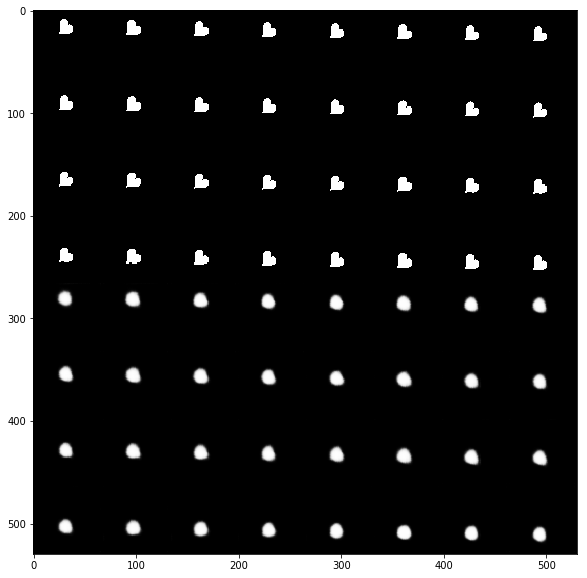

In [12]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10)) 
# Get a batch of data
for batch, labels in test_loader:
    break
    
#get best model,easrly stopping
viz = Visualizer(model)

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(torch.unsqueeze(batch,1).cuda().to(dtype=torch.float32))

# face
recon=np.rollaxis(recon.numpy(), 0, 3)  
print(recon[265:,:,:].min())
recon[:,:,:]=recon[:,:,:]
plt.imshow(recon[:,:,:].astype(float),cmap="gray",vmin=0, vmax=1)

#MNIST
# plt.imshow(recon.numpy()[0, :, :].astype(float), cmap='gray')
#plt.savefig(path+"/recon.png")




In [ ]:
test_batch = iter(test_loader)
test_batch = next(test_batch)
latent_dist,mask,_ = model.encode(torch.unsqueeze(test_batch[0],1).cuda().to(dtype=torch.float32))

print(mask,len(torch.nonzero(mask[0]==0)))

# for latent in latent_dist['cont'][0]:
#     count=torch.zeros((1,32))
#     latent[latent<1e-7]=0
    
#     for i in range(128):
    
#     #print(latent[i].size(),torch.nonzero(latent[i]))#len(torch.nonzero(latent[0]==0))
#         count[latent[i].reshape(1,32)!=0] += 1
#     print(count)
def show_idx(mask):
    a = mask.cpu().detach().numpy().squeeze()
    return np.array(np.where(a==1))+1
    

In [ ]:
def TCR():
    totalc = 0
    for batch, labels in test_loader:
        latent_dist, mask, reg = model.encode(torch.tensor(batch).cuda())
        mean, var = latent_dist['cont'][0]
        cov = covmatrix(mean)
        cov[torch.abs(cov)<=1e-6]=0
        cor = cov2cor(cov)
        totalc += np.sum(cor) 

    return totalc/len(test_loader)

def TCV():
    totalc = 0
    for batch, labels in test_loader:
        latent_dist,mask, reg = model.encode(torch.tensor(batch).cuda())
        mean, var = latent_dist['cont'][0]
        cov = covmatrix(mean).cpu().detach().numpy()
        cov = cov-np.diag(np.diag(cov))
        totalc += np.sum(cov**2) 
        
    return totalc/len(test_loader)


def covmatrix(mean):
    exp_mu = torch.mean(mean, dim=0)  #####mean through batch

    # expectation of mu mu.tranpose
    mu_expand1 = mean.unsqueeze(1)  #####(batch_size, 1, number of mean of latent variables)
    mu_expand2 = mean.unsqueeze(2)  #####(batch_size, number of mean of latent variables, 1) ignore batch_size, only transpose the means
    exp_mu_mu_t = torch.mean(mu_expand1 * mu_expand2, dim=0)

    # covariance of model mean
    cov = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1) 
    return cov
def cov2cor(c):
    #input batch * n_cont
    c = c.cpu().detach()
    d=np.zeros_like(c)
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            d[i,j]=c[i,j]/(np.sqrt(c[i,i]*c[j,j]+1e-10))
    return d
tcor=TCR()
tcov=TCV()
print(tcor,tcov)
trainer.evaluate(test_loader)

In [ ]:
###latent space T-SNE visualization
from sklearn.manifold import TSNE
import numpy as np

samples = torch.zeros(1)
labels = torch.zeros(1)
for i in range(10):
    test_batch = iter(test_loader)
    test_batch = next(test_batch)
    new_labels =torch.tensor(test_batch[1])
    latent_dist,_ ,_= model.encode(torch.tensor(test_batch[0]).cuda())
    new_samples = model.reparameterize(latent_dist)
    if torch.sum(samples) == 0:
        samples =new_samples
        labels = new_labels
    else:
        samples = torch.cat((samples,new_samples),0)
        labels = torch.cat((labels, new_labels),0)
    #print(samples.shape)
    
##latent_varibales should be N,D--->N,2


# latent_variables = samples.reshape(samples[0],-1)
tsne = TSNE(n_components=2)

tsne.fit_transform(samples.detach().cpu().numpy())

plt.scatter(tsne.embedding_[:,0],tsne.embedding_[:,1])
#plt.imshow()

In [ ]:
# import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


N = 10 # Number of labels

# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = tsne.embedding_[:,0]
y = tsne.embedding_[:,1]
tag = labels# Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,s=np.random.randint(100,110,N),cmap=cmap,     norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Custom cbar')
ax.set_title('Discrete color mappings')
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(path+"/scatter.png")
plt.show()




t-SNE demo
import numpy as np
from sklearn.manifold import TSNE
X = np.arange(40).reshape(5,4,2)

X_new = X.reshape(5,-1)
#X = np.array([[[0,0], [0,0], [0,0]], [[0,0], [0,1], [1,1]], [[1,1], [1,0], [0,1]], [[1,1], [1,1], [1,1]]])
print(X.shape,X)
print("--------")
print(X_new)

tsne = TSNE(n_components=2)
tsne.fit_transform(X)
print(tsne.embedding_)

# Plot samples

samples = viz.samples()
plt.imshow(samples.numpy()[0, :174, :], cmap='gray')
print(np.sum(samples.numpy()[0, :174, :]))
print(samples.numpy()[0, :, :].shape)
####origin
4*28

In [ ]:
# Plot samples
import matplotlib as mpl

#MNIST
# samples = viz.samples()
# sample=samples.numpy()[0, :, :]/2+0.5
# plt.imshow(sample, cmap='gray')
# plt.imsave(path+"/samples",samples.numpy()[0, :, :]/2+0.5, cmap='gray')

# face
fig = plt.figure(figsize=(50, 50)) 
samples = viz.samples()
samples = np.rollaxis(samples.numpy(), 0, 3)  
print(samples[:,:,0].max())
samples=(samples+1)/2
plt.imshow(samples.astype(float),norm = norm)
plt.imsave(path+"/samples",samples)
###DIP

In [ ]:
# Plot all traversals
fig = plt.figure(figsize=(30, 30))
traversals = viz.all_latent_traversals(size=10)

#MNIST
# plt.imshow(traversals.numpy()[0, :, :], cmap='gray')
# plt.imsave(path+"/all_traversals",traversals.numpy()[0, :, :], cmap='gray')

#face
traversals = np.rollaxis(traversals.numpy(), 0, 3)  
traversals=(traversals+1)/2
plt.imshow(traversals)
plt.imsave(path+"/all_traversals",traversals)
###dip[0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
#         0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.]

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=5, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))
#MNIST
# plt.imshow(traversals.numpy()[0, :, :], cmap='gray')
# plt.imsave(path+"/contVSdisc",traversals.numpy()[0, :, :], cmap='gray')

traversals.numpy()[0, :, :].max()
show_idx(mask)
#face
traversals = np.rollaxis(traversals.numpy(), 0, 3)
traversals=(traversals+1)/2
plt.imshow(traversals)
plt.imsave(path+"/contVSdisc",traversals)
##origin

all_t = viz.all_latent_traversals()
print(all_t.shape)
plt.imshow(all_t.numpy()[0, :, :], cmap='gray')
plt.imsave("figures/beta/all_",traversals.numpy()[0, :, :], cmap='gray')

In [ ]:
%matplotlib inline
import torch
import numpy as np
# Plot a grid of some traversals

fig = plt.figure(figsize=(70, 70))  # width, height in inches
print("continuous")
for i in range(n_cont):
    traversals = viz.latent_traversal_line(cont_idx=i, disc_idx=None,size=12)
    
    #MNIST
#     sub = fig.add_subplot(n_cont, 1, i + 1)
#     plt.savefig(path+"/cont{}.png".format(i))
#     plt.imshow(traversals.numpy()[0, :, :], cmap='gray')
    
    #FACE
    traversals = np.rollaxis(traversals.numpy(), 0, 3)
    sub = fig.add_subplot(n_cont, 1, i + 1)
    traversals=(traversals+1)/2
    plt.imshow(traversals)   
plt.savefig(path+"/cont.png")

show_idx(mask)
    

In [ ]:
print("discrete")
for i in range(n_disc):
    traversals = viz.latent_traversal_line(cont_idx=None, disc_idx=i,size=10)
    ##MNIST
#     sub = fig.add_subplot(n_disc, 1, i + 1)
#     plt.savefig(path+"/disc{}.png".format(i))
#     plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

    #FACE
    traversals = np.rollaxis(traversals.numpy(), 0, 3)
    sub = fig.add_subplot(n_disc, 1, i + 1)
traversals=(traversals+1)/2
plt.savefig(path+"/disc{}.png".format(i))
plt.imshow(traversals)

In [ ]:
import numpy as np
import torch
from latent_traversals import LatentTraverser
from scipy import stats
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
import numpy as np
import torch
from latent_traversals import LatentTraverser
from scipy import stats
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

    
# face    
def single_traversal(model,n_cont,cont_idx,cont_v,disc,disc_idx,prior):

        # Generate latent traversal
#         latent_samples = latent_traverser.traverse_line(cont_idx=cont_idx,
#                                                              disc_idx=disc_idx,
#                                                              size=size)
        dim = n_cont + sum(disc)
        if prior:
            latent_samples = torch.tensor(np.random.normal(size=(1, dim)))
        else:
            latent_samples= torch.zeros((1,dim))
            
        latent_samples[:,disc_idx+n_cont-1] = 1.0
        latent_samples[:,cont_idx]=cont_v
        

        # Map samples through decoder
        generated = decode_latents(model, latent_samples.float()).squeeze()
        generated  = np.rollaxis(generated.detach().numpy(), 0, 3)
        generated = (generated +1)/2
        print(generated.min(),generated.max())
        plt.imshow(generated)

        
def decode_latents(model, latent_samples):

        latent_samples = Variable(latent_samples)
        if model.use_cuda:
            latent_samples = latent_samples.cuda()
            result = model.decode(latent_samples).cpu()
        return result

#MNIST
# def single_traversal(model,n_cont,cont_idx,cont_v,disc,disc_idx,prior):

#        # Generate latent traversal
#         latent_samples = latent_traverser.traverse_line(cont_idx=cont_idx,
#                                                              disc_idx=disc_idx,
#                                                              size=size)
#         dim = n_cont + sum(disc)
#         if prior:
#             latent_samples = torch.tensor(np.random.normal(size=(1, dim)))
#         else:
#             latent_samples= torch.zeros((1,dim))
            
#         latent_samples[:,disc_idx+n_cont-1] = 1.0
#         latent_samples[:,cont_idx]=cont_v
        

#         # Map samples through decoder
#         generated = decode_latents(model, latent_samples.float()).squeeze()
#         plt.imshow(generated.detach().numpy(),cmap="gray")

        
# def decode_latents(model, latent_samples):

#         latent_samples = Variable(latent_samples)
#         if model.use_cuda:
#             latent_samples = latent_samples.cuda()
#         return model.decode(latent_samples).cpu()

In [ ]:
from ipywidgets import interact, fixed
from IPython.display import display
def interactive_view(model,n_cont,disc):
    
    
    interact(single_traversal,model=fixed(model),
             n_cont=fixed(n_cont), cont_idx=(0,n_cont,1), cont_v=(-2.5,2.5,0.5),
             disc=fixed(disc),disc_idx=(0,9,1),
             prior=True);
             
interactive_view(model,n_cont,disc)
show_idx(mask)